# Mortality Data Analysis

### Preprocessing

In [1]:
def education_calc(row):
    flag = row['education_reporting_flag']
    rev_89 = row['education_1989_revision']
    rev_03 = row['education_2003_revision']
    
    # 1989 recode
    if flag == 0:
        # If not stated
        if rev_89 == 99:
            return 0
        # If primary school or less
        elif rev_89 >= 0 and rev_89 <= 8:
            return 1
        # If some amount of secondary school
        elif rev_89 >= 9 and rev_89 <= 12:
            return 2
        # Complete or currently working on associate's or bachelor's degree
        elif rev_89 >= 13 and rev_89 <= 16:
            return 3
        # >4 years of school
        else:
            return 4
    # 2003 recode
    elif flag == 1:
        # "unknown"
        if rev_03 == 9:
            return 0
        # primary school
        elif rev_03 == 1:
            return 1
        # Some amount of secondary school
        elif rev_03 == 2 or rev_03 == 3:
            return 2
        # College up to bachelors
        elif rev_03 == 4 or rev_03 == 5 or rev_03 == 6:
            return 3
        # >4 years
        else:
            return 4
    # Nothing reported
    else:
        return 0

In [2]:
#File loading method stack overflow link: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#All dataframe methods learned from pandas documentation
#np.where learned from numpy documentation

import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


filename = 'MortalityCondensed.csv'
pd.set_option('display.max_columns',500)
pd.options.mode.chained_assignment = None 

def process_files(local_path):
    #Load all .csv files in the mortality directory
    all_files = glob.glob(local_path + "/*.csv")
    dataframe = pd.DataFrame()
    file_list = []

    for file in all_files:
        df = pd.read_csv(file, index_col = None, header = 0, low_memory = False)

        dfInterest = df[['sex','race','detail_age','month_of_death', 'manner_of_death', 'education_reporting_flag','education_2003_revision','education_1989_revision','hispanic_origin']] #Isolate columns we need
        dfInterest['binary_male'] = np.where(dfInterest['sex']=='M', 1, 0)
        dfInterest['manner_of_death_cleaned'] = np.where(np.isnan(dfInterest['manner_of_death']), 0, dfInterest['manner_of_death'])
        #dfInterest['binary_suicide'] = np.where(dfInterest['manner_of_death']==2, 1, 0) #create the binary suicide column

        #Recode education to get rid of NaNs. Code 18 represents where we have no data.
        dfInterest['education'] = dfInterest.apply(education_calc, axis=1)
        print(dfInterest['education'].head())

        #Recode race to give us more meaningful categories 0 hispanic, 1 white, 2 black, 3 asian
        dfInterest['binary_white'] = np.where(dfInterest['race'] == 1, 1, 0)
        dfInterest['binary_black'] = np.where(dfInterest['race'] == 2, 1, 0)
        dfInterest['binary_asian'] = np.where(dfInterest['race'] > 2, 1, 0)
        dfInterest['binary_hispanic'] = np.where(dfInterest['hispanic_origin'] > 199, 1, 0)        
        file_list.append(dfInterest) #add the new dataframe to the list
    
    dataframe = pd.concat(file_list) #concat the whole list to the final dataframe
    finaldf = dataframe.drop(columns=['race', 'sex', 'education_reporting_flag','education_2003_revision','education_1989_revision'])

    # Reordering
    finaldf = finaldf[['binary_male', 'binary_white', 'binary_black', 'binary_asian', 'binary_hispanic',
                      'detail_age', 'month_of_death', 'education','manner_of_death_cleaned']]
    finaldf.to_csv(filename)
    finaldf.head()
    print(finaldf.isnull().sum())#showing number of null values, shoulw be 0 after recode


## Main

In [3]:
# Check if base_file exists
# If not, create it
if not os.path.isfile(filename):
    process_files("mortality")
df = pd.read_csv(filename, header=0, encoding='ISO-8859-1', engine='python')
#new_df = df.sample(int(len(df)/4))
#print(new_df.head())
# Split into training and test
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
df = df[df.manner_of_death_cleaned != 0]
print(df['manner_of_death_cleaned'].value_counts())

msk = np.random.rand(len(df)) < 0.9
train = df[msk]
test = df[~msk]

Y_train = np.where(train.iloc[:,len(train.columns)-1] == 3, 1, 0)
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = np.where(test.iloc[:,len(test.columns)-1] == 3, 1, 0)
X_test = test.iloc[:,1:(len(test.columns)-1)]

#Y_train = train.iloc[:,len(train.columns)-1]
#Y_test = test.iloc[:,len(test.columns)-1]

7    839
1     80
2     47
3     22
5     12
Name: manner_of_death_cleaned, dtype: int64


In [4]:
train

,Unnamed: 0,binary_male,binary_white,binary_black,binary_asian,binary_hispanic,detail_age,month_of_death,manner_of_death_cleaned
0,0,1,1,0,0,0,84,1,7
1,1,1,1,0,0,0,70,1,7
2,2,0,1,0,0,0,91,1,7
3,3,0,0,0,1,0,40,1,3
4,4,0,1,0,0,0,89,1,7
5,5,1,0,0,1,0,78,1,7
6,6,1,1,0,0,0,92,1,7
7,7,1,1,0,0,0,82,1,7
9,9,0,1,0,0,0,93,1,7
10,10,0,1,0,0,0,84,1,7


## Predicting Suicide vs Non-Suicide

### Logistic Regression

The best estimators are: 
SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       epsilon=array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
       eta0=0.0, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='log', max_iter=None, n_iter=None, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)


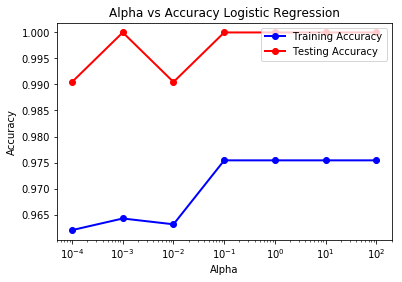

[0.9620111731843576, 0.964245810055866, 0.9631284916201117, 0.9754189944134078, 0.9754189944134078, 0.9754189944134078, 0.9754189944134078]
[0.9904761904761905, 1.0, 0.9904761904761905, 1.0, 1.0, 1.0, 1.0]
CPU times: user 1.2 s, sys: 424 ms, total: 1.62 s
Wall time: 1.31 s


In [7]:
%%time
#sources http://scikit-learn.org/stable/modules/sgd.html
#running gridsearchCV on a generic SGCclassifier to seek out optmized meta-paramaters
#########GRIDSEARCH##########################
from sklearn import grid_search
param_grid = {
    'loss': ['log'],
    'penalty': ['elasticnet'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 1],
    'epsilon':[10.0**-np.arange(1,7)]
}

SGC_generic = SGDClassifier(random_state=0, class_weight='balanced')

SGC_generic_gridsearch = grid_search.GridSearchCV(estimator=SGC_generic, param_grid=param_grid,
                                    n_jobs=-1, scoring='roc_auc')

SGC_generic_gridsearch.fit(X=X_train, y=Y_train)
print"The best estimators are: "
print SGC_generic_gridsearch.best_estimator_
#########GRIDSEARCH##########################

alpha_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
#alpha_arr = [0.01]
train_acc = []
test_acc = []
for a in alpha_arr:    
    classifier = SGDClassifier(loss='log', max_iter=200, tol=1.0e-9, random_state=123, alpha=a)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))

plt.figure(1)
plt.plot(alpha_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(alpha_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

ax = plt.gca()
ax.set_xscale('log')

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)


In [6]:
### ONLY USEFUL IF WE USE GRIDSEARCH CV, MIGHT BE TOO SLOW
# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(log_reg_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

# Load data
log_reg_res = {}
with open(log_reg_fn, 'rb') as f:
    log_reg_res = pickle.load(f)

NameError: name 'log_reg_fn' is not defined

### Decision Tree

The best estimators are: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
[0.         0.03829542 0.50483951 0.         0.         0.45686506
 0.        ]
[0.04072497 0.02567199 0.33842778 0.         0.         0.51177424
 0.08340102]
[0.05634828 0.01653942 0.24061834 0.         0.         0.56584908
 0.12064487]
[0.08831643 0.09539003 0.15180102 0.04749074 0.         0.41977552
 0.19722626]
[0.07454837 0.0221701  0.12813605 0.07171153 0.         0.53250006
 0.17093387]
[0.05240405 0.034163   0.12319742 0.06894762 0.         0.53767113
 0.18361679]
[0.04598036 0.04272792 0.12319742 0.04753531 0.         0.51625883
 0.22430016]
[0.04598036 0.07741585 0.12319742 0.02569476 0.         0.50341145


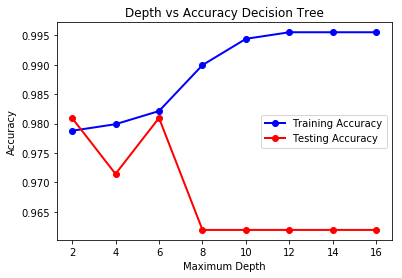

[0.9787709497206704, 0.9798882681564246, 0.982122905027933, 0.9899441340782122, 0.994413407821229, 0.9955307262569832, 0.9955307262569832, 0.9955307262569832]
[0.9809523809523809, 0.9714285714285714, 0.9809523809523809, 0.9619047619047619, 0.9619047619047619, 0.9619047619047619, 0.9619047619047619, 0.9619047619047619]
CPU times: user 5.31 s, sys: 512 ms, total: 5.82 s
Wall time: 5.53 s


In [14]:
%%time
###############GridsearchCV#############
param_grid = {'max_depth': np.arange(1,100),
             'min_samples_leaf':[1**x for x in range(1,10)]
             }
generic_tree =DecisionTreeClassifier()
gridsearch_generic_tree = grid_search.GridSearchCV(estimator=generic_tree, param_grid=param_grid,
                                    n_jobs=-1, scoring='roc_auc');
gridsearch_generic_tree.fit(X=X_train, y=Y_train)
print"The best estimators are: "
print gridsearch_generic_tree.best_estimator_
#######################################

depth_arr = [2,4,6,8,10,12,14,16]
#depth_arr = [10]
train_acc = []
test_acc = []

for d in depth_arr:    
    clf = DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train, Y_train)
    print(clf.feature_importances_)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, clf.predict(X_test)))

plt.figure(1)
plt.plot(depth_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(depth_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.title("Depth vs Accuracy Decision Tree")
plt.legend(loc='center right')
plt.show()

print(train_acc)
print(test_acc)

## Random Forest 


In [22]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Using 10 trees. (Will attempt more in the future after tuning.)
rforest = RandomForestClassifier(n_estimators=10, random_state=0)

param_grid = { 
    'n_estimators': [1,10,200,700],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)
print CV_rfc.best_params_
rforest.fit(X_train, Y_train)

{'max_features': 'auto', 'n_estimators': 10}
CPU times: user 34.8 s, sys: 80 ms, total: 34.9 s
Wall time: 34.8 s


In [21]:
#Reflect accruacy.
ypred = rforest.predict(X_test)
print(metrics.classification_report(Y_test, ypred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99        96
          1       0.00      0.00      0.00         2

avg / total       0.96      0.98      0.97        98



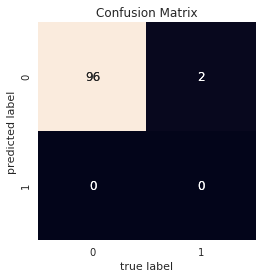

In [18]:
#Attempt at confusion matrix. Need to clean this up a bit.
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(Y_test, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



### ROC (Binary)

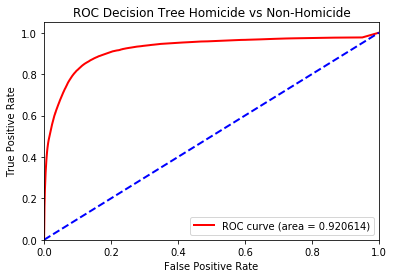

In [22]:
# ROC stuff
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(2)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree Homicide vs Non-Homicide')
plt.legend(loc="lower right")
plt.show()

### ROC (Multiclass)

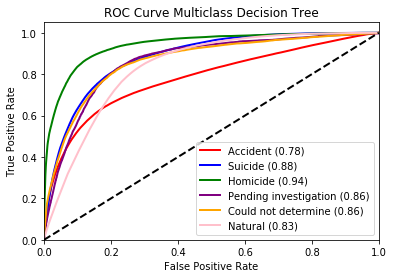

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# Example from
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

# Must use 1 vs rest as ROC doesn't do "actual" multiclass
classifier = OneVsRestClassifier(DecisionTreeClassifier(max_depth=10), n_jobs=6)
# Must also binarize y_test for onevsrest
binary_y_test = label_binarize(Y_test, classes=[1, 2, 3, 4, 5, 7])

classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)
n_classes = 6

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# For all classes, calculate and store true, false positive rate, area under curve
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
labels = ['Accident', 'Suicide', 'Homicide', 'Pending investigation', 'Could not determine', 'Natural']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} ({1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass Decision Tree')
plt.legend(loc="lower right")
plt.show()

### Linear SVM

In [ ]:
svm_fn = 'svm_gridsearch_output.pkl'

# Base svm classifier
base_classifier = SGDClassifier(max_iter=1000, tol=1.0e-12, random_state=123)
# Define alpha as param to search over
svm_alpha_arr = np.asarray([0.0001, 0.001, 0.01, 0.1, 1.0])
params = {'alpha': svm_alpha_arr}
# Fit to training data, 5 fold CV
gs_classifier = GridSearchCV(base_classifier, params, scoring='accuracy', cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test)))

# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(svm_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

In [ ]:
# Load data
svm_res = {}
with open(log_reg_fn, 'rb') as f:
    svm = pickle.load(f)
    
plt.figure(1)
plt.plot(svm_alpha_arr, svm_res['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Accuracy")
plt.plot(svm_alpha_arr, svm_res['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()

## Multiclass Classification on Manner of Death

### Multinomial Logistic Regression

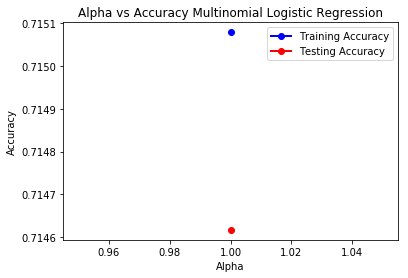

[0.7150782639134419]
[0.7146173113304088]


In [28]:
#c_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
'''
c_arr = [1.0]
train_acc = []
test_acc = []
for c in c_arr:    
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123, C=c)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))
'''
plt.figure(1)
plt.plot(c_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(c_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Multinomial Logistic Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)

# Unsupervised Analysis

# Cause of Death

## Clustering Causes of Death

In [1]:
import json

with open('./mortality/2015_codes.json') as f:
    d = json.load(f)
    print(d)

{'resident_status': {'1': 'RESIDENTS', '2': 'INTRASTATE NONRESIDENTS', '3': 'INTERSTATE NONRESIDENTS', '4': 'FOREIGN RESIDENTS'}, 'education_1989_revision': {'00': 'No formal education', '01-08': 'Years of elementary school', '09': '1 year of high school', '10': '2 years of high school', '11': '3 years of high school', '12': '4 years of high school', '13': '1 year of college', '14': '2 years of college', '15': '3 years of college', '16': '4 years of college', '17': '5 or more years of college', '99': 'Not stated'}, 'education_2003_revision': {'1': '8th grade or less', '2': '9 - 12th grade, no diploma', '3': 'high school graduate or GED completed', '4': 'some college credit, but no degree', '5': 'Associate degree', '6': 'Bachelor’s degree', '7': 'Master’s degree', '8': 'Doctorate or professional degree', '9': 'Unknown'}, 'education_reporting_flag': {'0': '1989 revision of education item on certificate', '1': '2003 revision of education item on certificate', '2': 'no education item on ce

## K-Means Clustering

In [4]:
from sklearn.cluster import KMeans

matrix = df.as_matrix()
kmeans = KMeans(n_clusters = 3)
kmeans.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Text(0.5,1,'Education vs. Age 3-Cluster')

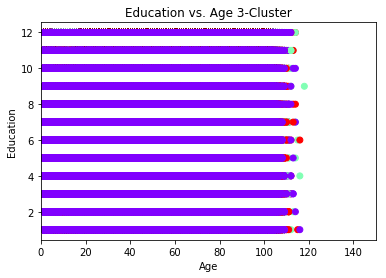

In [5]:
plt.scatter(matrix[:,6], matrix[:,7], c=kmeans.labels_, cmap='rainbow')
plt.xlim(right = 150)
plt.xlim(left = 0)
plt.xlabel('Age')
plt.ylabel('Education')
plt.title('Education vs. Age 3-Cluster')

In [6]:
kcluster = range(1,7)
kmeans_arr = []
kmeans_score = []

for k in kcluster:
    kmeans_arr.append(KMeans(n_clusters = k))
    kmeans_score.append(kmeans_arr[k-1].fit(matrix).score(matrix))

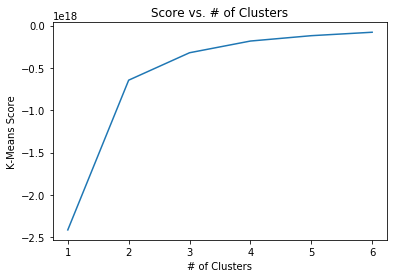

In [7]:
plt.plot(kcluster,kmeans_score)
plt.xlabel('# of Clusters')
plt.ylabel('K-Means Score')
plt.title('Score vs. # of Clusters')
plt.show()